# Journey 4
## Part 1

### Transfer Learning 

Transfer learning is where a model trained for one task is used as the starting point of another model (task). The intution is that the pre-trained model has captured something intrinsic (generalised) about the space we want the new (derived) model to operate in.

There are many very complex models that take a huge amount of data, compute time and hyper paramater tuning to get operational. If we have a task that is similar in nature to task the original model was trained for we can stand on shoulders of giants and adapt the model with a small amount of re-training and our domain specific data.

Some examples of complex pre-trained models would be [Google BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) a sophitocaed NLP model or [Mask R-CNN](https://github.com/matterport/Mask_RCNN) or [YOLOv2](https://github.com/experiencor/keras-yolo2) or ...


### Our Example

We can obtain the intution for the process but to make it tractable we chose a very simple model so we can train it as part of this notebook. Clearly a model this simple would not be a valid real work case as it's cheep enough just to retain - but for the purpose of gaining itution it will work well.

Let's suppose we are a Supermarket and we need to be able to accuratly classify differnet types of apple via an optical feed. We find a very powerful pre-trained model that does exactly what we want but it's missing some of the specific types of apple we are interested in. How can we make use of all the hard work and compute that went into the pre-trained model without starting over again ??

### What's the intution ?

When we look at the model we see it is a type of CNN with a few fully connected layers. Our postulation is that the CNN layers will have generalised aspects of Apple that we could leverage. However the version of the model only classifies 6 types of Apple and the one we are interested in is not in that group. 

We cannot use the model as it what could we do ?

Well, what if we could take the pre-trained CNN bit and plug it onto a new 7 class classifier and do a minimal amount of re-training where we make the most of the pre-trained CNN weights ?.

If we are carful we can

1. We take the trained model
2. Save the CNN layers
3. Replicate the CNN architecture
4. Create a new fully connected set of layers that give us the extra class we need
5. Re-create a new model by joining the same type CNN layers onto the new fully connected layers
    * we can do this as long as the input layer to the fully connected matches the output layer of the CNN
6. Load just the CNN layers into the new model
    * this works becuse the CNN layers in the new model were made to replicate exactly the pre-trained model
    * so this should allow us to inherit all of the generalisation of Apple captured during the original training.
7. We can then do a small amount (we hope) of re-training to get a seven apple classifer
    * At least we hope it is less work than starting from scratch.

### The model.

As we can see, the green bit is the CNN we want to re-use and the blue bit is the bit we want to replace.

Check out the [artilce](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/) if you want a quick reminder on the details of CNN in Keras.

![Apple CNN](./images/AppleCNN-1.png)

### The Save and Re-Use

As we can see below, we save the original model weights and load them into a new model that has the same CNN layers but a new fully connected module with a 7 class output instead of a 6 class output. The new FC layer can be joined to the original CCN structure as we ensure the new FC input matches the CNN output layer

![CNN Save & Load](./images/AppleCNN-2.png)

### Let's get going

The data set we are going to use is from [Kaggle](https://www.kaggle.com/) and there is one that classifies many types of fruit including a range of apples. This is the [fruit 360](https://www.kaggle.com/moltean/fruits) data set.

In [1]:
#
# Some libraries we will need along the way.
#
from os import listdir
from os.path import isdir, isfile, join
import re
import random
import re
import os
import sys

import numpy as np 
from PIL import Image # Great for image loading and manipulation.

In [16]:
#
# We create a data directory in the directory above our current location into which the download all of the data. You will then
# see there is a training and a test data set defined.
#
DATA_DIR = '../../data'
TEST_DATA = DATA_DIR + '/Test'
TRAIN_DATA = DATA_DIR + '/Train'

#### One Hot
We are writting a classifer so we need a function to generate [one-hot](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) encoding of the image classifiction.

In [6]:
#
# Create a one-hot encoding for the given list
#
def create_one_hot_encoding_dicts(list_to_encode):
    list_to_one_hot = dict()
    one_hot_to_item = dict()
    for i, l in enumerate(list_to_encode):
        oh = np.zeros((len(list_to_encode)))
        oh[i] = 1
        list_to_one_hot[l] = oh
        one_hot_to_item[np.array2string(oh)] = l
    return list_to_one_hot, one_hot_to_item

In [7]:
#
# Return a list of only the JPG files for a given dir
#
def list_files(data_dir):
    jpg_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f)) and re.search('\.jpg$',f,flags=re.IGNORECASE)]
    return jpg_files

#### Load Data 

We need a function to get the images and their classification as the traditional x_train, y_train, x_test and y_test arrays. So this function takes a list of fruit (files names) to load and does just that.

The **Y** matricies are one-hot encoded by mapping the file names. So if there are 4 files given we create a 4 column one-hot vector where file name one is column 2, file name 2 is column 2 and so on.

In [8]:
#
# Load a given list of fruits from the selected data set location
#
def load_data(fruits_to_get, 
              test_data_dir,
              train_data_dir
             ):
    
    one_hot_dict, item_dict = create_one_hot_encoding_dicts(fruits_to_get)
        
    test_data = []
    train_data = []
    
    for fruit in fruits_to_get:
        
        test_fruit_dir = test_data_dir + "/" + fruit
        train_fruit_dir = train_data_dir + "/" + fruit
        
        if isdir(test_fruit_dir) and isdir(train_fruit_dir):
            one_hot_val = one_hot_dict[fruit]
            
            print("loading [" + fruit + "]" + " one hot: " + str(one_hot_val))
            
            print('Test Data')
            for img_file in list_files(test_fruit_dir):
                test_data.append([np.array(Image.open(join(test_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            print('Training Data')
            for img_file in list_files(train_fruit_dir):
                train_data.append([np.array(Image.open(join(train_fruit_dir,img_file))), one_hot_val])
                print('.', end='')
            print('')

            img_shape = test_data[0][0].shape
            one_hot_shape = test_data[0][1].shape
            
            # Convert data to numpy
            x_test = np.zeros((len(test_data), *img_shape))
            y_test = np.zeros((len(test_data), one_hot_shape[0]))
            x_train = np.zeros((len(train_data), *img_shape))
            y_train = np.zeros((len(train_data), one_hot_shape[0]))
            
            i = 0 
            rnd_idx = random.sample(range(0, len(test_data)), len(test_data))
            for img, one_hot in test_data:
                x_test[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_test[rnd_idx[i]] = one_hot
                i += 1

            i = 0 
            rnd_idx = random.sample(range(0, len(train_data)), len(train_data))
            for img, one_hot in train_data:
                x_train[rnd_idx[i]] = img / 255.0  # rescale 0.0 to 1.0
                y_train[rnd_idx[i]] = one_hot
                i += 1

        else:
            raise Exception("Cannot load unknown fruit - missing from test and/or train data set[" + fruit + "]")
            
    return x_train, \
           y_train, \
           x_test, \
           y_test, \
           one_hot_dict, \
           item_dict
        

#### Get the Six Classes

In our test case we don't have a fancy model that we can re use. So need to create it and then re-use it.

So here we load six apple data sets that we will train a classification model with. We will then pretend this is the model we want to re-use via transfer learning.

Let's kick off by loading six types of apple.

In [17]:
list_to_get = ["Apple Golden 1",
               "Apple Golden 2",
               "Apple Golden 3",
               "Apple Red 1",
               "Apple Red 2",
               "Apple Red 3"]              
x_train, y_train, x_test, y_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

loading [Apple Golden 1] one hot: [1. 0. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
loading [Apple Golden 2] one hot: [0. 1. 0. 0. 0. 0.]
Test Data
....................................................................................................................................................................
Training Data
.....................

#### What did we get ?

We used Pillow library to load the images and convert them into three layer matricies. So when we print the shapes below you will see that we have 961 test images of (100 x 100 x 3). Where 100 x 100 is the number of pixels and 3 are the three separate RGB layers.

There is also x_train which is the same 100 x 100 x 3 except we have 2878 images. 

Plus the corresponding one-hot encoded Y matrices each with six columns representing the six classes of Apple we have encoded.


In [18]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
        

(961, 100, 100, 3)
(961, 6)
(2878, 100, 100, 3)
(2878, 6)


#### What do they look like ?

Let's show nine randomly selected images using matcplot lib to visualise them.

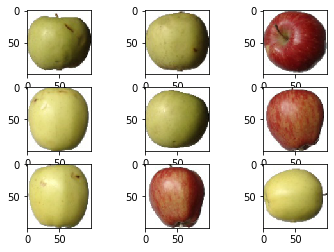

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline  

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], interpolation='none')

### Onto the model

We need to create the model that will play the real world role of a model we want to re-use.

For this we will use the [Keras](https://keras.io/) library backed by [Tensorflow](https://www.tensorflow.org/).

In [20]:
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


#### How fast can we go ?

If you have GPU's and the Jupyter Kernel has the correct version of Keras and Tensorflow you will be able to enable GPU for this exerice to speed up your training. The command below will show you how many GPU's you have if any.

Getting GPU's running can be tricky and you will also need an GPU comatible with CUDA. There are many great [articles](https://www.linkedin.com/pulse/set-up-gpu-accelerated-tensorflow-keras-windows-10-anaconda-bhatia) on line for how to do this. If in doubt set GPU count = 0 and everything will still work - just a bit slower.

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17492726191952972190
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4944779673
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9927540320404342009
physical_device_desc: "device: 0, name: GeForce GTX TITAN Z, pci bus id: 0000:04:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 4944779673
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 367955204235523305
physical_device_desc: "device: 1, name: GeForce GTX TITAN Z, pci bus id: 0000:05:00.0, compute capability: 3.5"
]


In [22]:
#
# Set this to Zero if you are not sure you have GPU's enabled.
#
GPU_COUNT = 0

#### The CNN Layers

This function builds the CNN layers that we use to compose our final model.

In [23]:
def build_cnn_layers(model_name,
                     input_shape):
    cnn_in = Input(shape=input_shape, name = "cnn0Input")
    cnn_l1 = Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', name = "cnn1_Conv2d")(cnn_in) 
    cnn_l2 = MaxPooling2D(pool_size=(2, 2), name = "cnn2_MaxPool2D")(cnn_l1)
    cnn_l3 = BatchNormalization(name = "cnn3_BatchNorm")(cnn_l2) 
    cnn_l4 = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', name = "cnn3_conv2d")(cnn_l3)
    cnn_l5 = MaxPooling2D(pool_size=(2, 2), name = "cnn5_MaxPool2D")(cnn_l4)
    cnn_l6 = BatchNormalization(name = "cnn6_BatchNorm")(cnn_l5) 
    cnn_l7 = Dropout(rate=0.25,name = "cnn7_Dropout")(cnn_l6) 
    cnn_out = Flatten(name = "cnnOutput_Flatten")(cnn_l7)
    return cnn_in, cnn_out

In [24]:
def build_cnn_layers(model_name,
                     input_shape):
    cnn_in = Input(shape=input_shape, name = "cnn0Input")
    cnn_l1 = Conv2D(16, kernel_size=(5, 5), strides=(2, 2), activation='relu', name = "cnn1_Conv2d")(cnn_in) 
    cnn_l2 = MaxPooling2D(pool_size=(2, 2), name = "cnn2_MaxPool2D")(cnn_l1)
    cnn_l3 = BatchNormalization(name = "cnn3_BatchNorm")(cnn_l2) 
    cnn_l7 = Dropout(rate=0.25,name = "cnn7_Dropout")(cnn_l3) 
    cnn_out = Flatten(name = "cnnOutput_Flatten")(cnn_l7)
    return cnn_in, cnn_out

#### Fully Connected Layers

This function creates our fully connected classification layers and is given the CNN output layer to bind to and the number of classes for its output.

In [25]:
def build_classifier_layers(model_name,
                            num_classes,
                            input_layer):
    cl_l1 = Dense(25, activation='relu', name = "clInput_Dense")(input_layer) # 500 -> 50
    cl_l2 = Dropout(rate=0.25, name = "cl1_Dropout")(cl_l1)
    cl_out = Dense(num_classes, activation='softmax', name = "clOutput")(cl_l2)
    return cl_out

#### The final model

We compose the final model from both the CNN & FC layers

In [26]:
def create_model(model_name,
                input_shape,
                num_classes):
    model_cnn_in, model_cnn_out = build_cnn_layers(model_name, input_shape)
    model_cl_out = build_classifier_layers(model_name, num_classes, model_cnn_out)

    model = Model(inputs=[model_cnn_in],outputs=[model_cl_out])
    model.name = model_name
    return model

We define the input shape of 100 x 100 x 3 to match the images we have already loaded and define the number of classes to be six to match the number of different apples we loaed.

Once we have created the model - we show a text summary of it so you can see all the layers. These are the layers we will be working with later. **Note** that we have named all of the layers and all of the <code>cnn</code> layers start with 'cnn'. We need this so that we can later both save and re load all of the cnn specific layers.

In [27]:
input_shape = (100, 100, 3)
num_classes = 6
model_name = "classifier_" + str(num_classes)

model = create_model(model_name, input_shape, num_classes)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn0Input (InputLayer)       (None, 100, 100, 3)       0         
_________________________________________________________________
cnn1_Conv2d (Conv2D)         (None, 48, 48, 16)        1216      
_________________________________________________________________
cnn2_MaxPool2D (MaxPooling2D (None, 24, 24, 16)        0         
_________________________________________________________________
cnn3_BatchNorm (BatchNormali (None, 24, 24, 16)        64        
_________________________________________________________________
cnn7_Dropout (Dropout)       (None, 24, 24, 16)        0         
_________________________________________________________________
cnnOutput_Flatten (Fl

We need to compile the model before we train it and this is where we let Keras and Tensorflow know if they need to take GPUs into account.

In [28]:
def model_compile(model,
                 num_gpu):
    if num_gpu > 0:
        model = multi_gpu_model(model, gpus=num_gpu)
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(lr=0.01),
                  metrics=['accuracy'])
    return model

In [29]:
model = model_compile(model, GPU_COUNT)

### Train the model.

Here we train the model and in a real world example this is where much parameter tuning and compute would be consumed. Which is why there are cases we would like to re-use the model. In our example case it's quite quick to train so there is not much to be gained. However we will still be able to understand the exact process with this example.

This may take a while if you just have CPU so be patient - worst case you can reduce the <code>num_epocs</code> to 20 and it should still be fine.

In [30]:
batch_size = 32
num_epochs = 50
history = model.fit(x_train, y_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, y_test)
                    )

Instructions for updating:
Use tf.cast instead.
Train on 2878 samples, validate on 961 samples
Epoch 1/50
2878/2878 [==============================] - 3s 887us/step - loss: 1.0836 - acc: 0.5796 - val_loss: 1.9394 - val_acc: 0.2518
Epoch 2/50
2878/2878 [==============================] - 1s 471us/step - loss: 0.3778 - acc: 0.8742 - val_loss: 0.1959 - val_acc: 0.9376
Epoch 3/50
2878/2878 [==============================] - 1s 468us/step - loss: 0.2553 - acc: 0.9104 - val_loss: 0.4084 - val_acc: 0.8522
Epoch 4/50
2878/2878 [==============================] - 1s 467us/step - loss: 0.1776 - acc: 0.9347 - val_loss: 0.0376 - val_acc: 0.9958
Epoch 5/50
2878/2878 [==============================] - 1s 468us/step - loss: 0.1480 - acc: 0.9454 - val_loss: 0.0747 - val_acc: 0.9938
Epoch 6/50
2878/2878 [==============================] - 1s 471us/step - loss: 0.1172 - acc: 0.9573 - val_loss: 0.0524 - val_acc: 0.9938
Epoch 7/50
2878/2878 [==============================] - 1s 470us/step - loss: 0.1227 - ac

#### Check Training

Let's graph the accuracy and the loss and see how it went

In [31]:
def plot_results(history,
                 num_epochs):
    color_r = 'tab:red'
    color_b = 'tab:blue'
    
    epocs = np.arange(0, num_epochs)

    fig, _ = plt.subplots(figsize=(15,6))
    
    # Loss
    ax1 = plt.subplot(1,2,1)
    plt.title('Loss')
    ax1.set_xlabel('Epoc')
    ax1.set_ylabel('Traing Loss', color=color_r)
    ax1.plot(epocs, history.history['loss'], color=color_r)
    ax1.tick_params(axis='y', labelcolor=color_r)
    ax2 = ax1.twinx()  # 2nd Axis for Validation Loss
    ax2.set_ylabel('Validation Loss', color=color_b)  
    ax2.plot(epocs, history.history['val_loss'], color=color_b)
    ax2.tick_params(axis='y', labelcolor=color_b)

    # Accuracy
    ax1 = plt.subplot(1,2,2)
    plt.title('Accuracy')
    ax1.set_xlabel('Epoc')
    ax1.set_ylabel('Traing accuracy', color=color_r)
    ax1.plot(epocs, history.history['acc'], color=color_r)
    ax1.tick_params(axis='y', labelcolor=color_r)
    ax2 = ax1.twinx()  # 2nd Axis for Validation Loss
    ax2.set_ylabel('Validation Accuracy', color=color_b)  
    ax2.plot(epocs, history.history['val_acc'], color=color_b)
    ax2.tick_params(axis='y', labelcolor=color_b)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    return

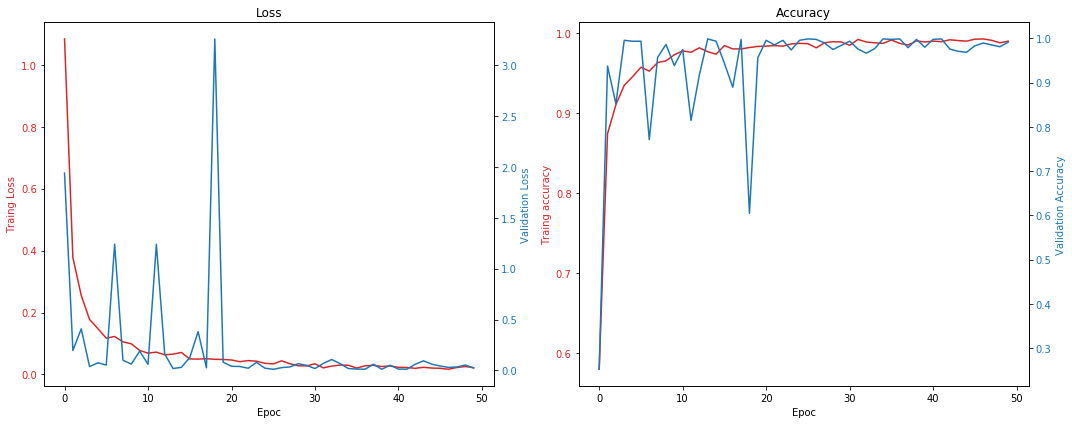

In [32]:
plot_results(history, num_epochs)

You should see the red lines showing steady progress as the training progresses - the blue (validation) line will be a little jagged but should be less jagged as training progresses.

Next we will run some predictions of our own on the test data and see what our preduction capability is.

In [33]:
def test_model_prediction(model,
                          x_test_set, 
                          y_test_set,
                          num_to_test,
                          summary = True):
    num_passed = 0
    list_to_test = np.random.randint(len(x_test_set), size=num_to_test)

    for i in list_to_test:
        xt = x_test_set[i]
        xt = np.reshape(xt,(1,100,100,3))
        pred = model.predict(xt)
        if(np.argmax(pred) == np.argmax(y_test_set[i])):
            if not summary:
                print("Correct Prediction for x_test element: " + str(i)) 
            num_passed += 1
        else:
            if not summary:
                print("Failed Prediction for x_test element: " + str(i))
    print("\nOverall Score : "+ str(round(num_passed/num_to_test,1)*100)+"%")
    return

In [34]:
test_model_prediction(model, x_test, y_test, 900, summary=True)


Overall Score : 100.0%


How did it do ? should be at or above about 90% ?

### Save it !

We need to save the weights model layers as these are now trained and valuable. For this we write a simple function to iterate all of the layers and save each layer as separate file. The file name is the name of the layer and e use standard numpy capability to save the weights as they are just numpy matricies.

In [35]:
#
# Returns the model layers. If we complied with GPU we need to look in a different place to find the actual model 
# and its weigths.
#
def model_layers(model):
    try:
        layers = model.get_layer(model_name).layers
    except:
        layers = model.layers
        
    return layers

In [36]:
# 
# This function saves the layers that match a certian pattern, remember we named each layer so we could save and load layers
# by name.
#
cnn_only = ".*cnn.*"
def aij_save_cnn_layers(model,
                        pattern=".*"):

    for l in model_layers(model):
        l_name = l.name
        if re.search(pattern, l_name):
            w = l.get_weights()
            print('Saving Layer :'+ l.name + ":: params #"+str(l.count_params()))
            np.save(l_name + '.npy', w, allow_pickle=True)
    return

Ok, so we are going to save **all** the layers both the CNN abd the FC - this is what you may see if a saved model was made public. We only need the CNN layers so when we load them later we can just pick the right ones.

In [37]:
aij_save_cnn_layers(model, pattern= ".*")

Saving Layer :cnn0Input:: params #0
Saving Layer :cnn1_Conv2d:: params #1216
Saving Layer :cnn2_MaxPool2D:: params #0
Saving Layer :cnn3_BatchNorm:: params #64
Saving Layer :cnn7_Dropout:: params #0
Saving Layer :cnnOutput_Flatten:: params #0
Saving Layer :clInput_Dense:: params #230425
Saving Layer :cl1_Dropout:: params #0
Saving Layer :clOutput:: params #156


Let's run a quick shell command and see if we can see all the saved files. You will need to change the shell command to
<br><code>!ls *.npy</code><br>
if you launched your jupyter notebook server from a linux shell.

In [38]:
!dir *.npy

 Volume in drive D is DATA
 Volume Serial Number is BA17-7272

 Directory of D:\Dev\devroot\Docker\AI-Intuition\journeys\journey-4

11/24/2019  08:53 PM               128 cl1_Dropout.npy
11/24/2019  08:53 PM         1,402,190 clInput_Dense.npy
11/24/2019  08:53 PM             1,431 clOutput.npy
11/24/2019  08:53 PM               128 cnn0Input.npy
11/24/2019  08:53 PM             7,897 cnn1_Conv2d.npy
11/24/2019  08:53 PM               128 cnn2_MaxPool2D.npy
11/24/2019  08:53 PM               384 cnn3_BatchNorm.npy
11/24/2019  08:53 PM               128 cnn7_Dropout.npy
11/24/2019  08:53 PM               128 cnnOutput_Flatten.npy
               9 File(s)      1,412,542 bytes
               0 Dir(s)  2,835,783,462,912 bytes free


### Re Load.

Before we get into the new transfer learning model, lets see if we can create a new six classifer model re-load the weights and get it to make good predictions. This will prove to us the saved weights have value and that its possible to get a model running without training from scratch.


In [39]:
#
# We need a function that will take a model and load layers with names that match a given pattern.
#
def aij_load_cnn_layers(model,
                        pattern = ".*",
                        trainable = True):
    
    for l in model_layers(model):
        try:
            if re.search(pattern, l.name):
                w = np.load(l.name+'.npy',allow_pickle=True)
                l.set_weights(w)
                l.trainable = trainable
                print("Loaded weights for Layer: " + l.name + 'Trainable: ' + str(trainable))
            else:
                print("Ignored Layer:" + l.name + " as it does not match load pattern")
        except IOError as e:
            print("No loadable weights for Layer: "+l.name) 
        except:
            print("Unexpected error:", sys.exc_info()[0])
    return

**Note** for the load to work the model being loaded into must have layers that match exactly the model where the layers were saved from.

#### Re run .. 

We create a **six** classifer model identical to the original but instead of training it we load the weights !.

In [40]:
# Model strcuture changes when complied for GPU, so we need to look in diffent places for the 'actual' layers
def aij_model_summary(model):
    
    for l in model_layers(model):
        print(l.name+":: params #"+str(l.count_params()))
    return

In [41]:
#
# Same model as before but we create it from scratch so it is not trained.
#
input_shape = (100, 100, 3)
num_classes = 6
model_name = "classifier_reload_test" + str(num_classes)

model_reload_test = create_model(model_name, input_shape, num_classes)
model_reload_test = model_compile(model_reload_test, GPU_COUNT)
aij_model_summary(model_reload_test)


cnn0Input:: params #0
cnn1_Conv2d:: params #1216
cnn2_MaxPool2D:: params #0
cnn3_BatchNorm:: params #64
cnn7_Dropout:: params #0
cnnOutput_Flatten:: params #0
clInput_Dense:: params #230425
cl1_Dropout:: params #0
clOutput:: params #156


Let's do a quick test and see how he model does before we load weights ... it should have a very poor performance

In [42]:
test_model_prediction(model_reload_test, x_test, y_test, 100)


Overall Score : 10.0%


Now let's load the model weight and re-compile the model

In [43]:
aij_load_cnn_layers(model_reload_test)
model = model_compile(model, GPU_COUNT)

Loaded weights for Layer: cnn0InputTrainable: True
Loaded weights for Layer: cnn1_Conv2dTrainable: True
Loaded weights for Layer: cnn2_MaxPool2DTrainable: True
Loaded weights for Layer: cnn3_BatchNormTrainable: True
Loaded weights for Layer: cnn7_DropoutTrainable: True
Loaded weights for Layer: cnnOutput_FlattenTrainable: True
Loaded weights for Layer: clInput_DenseTrainable: True
Loaded weights for Layer: cl1_DropoutTrainable: True
Loaded weights for Layer: clOutputTrainable: True


Now if we test the model it should do very well - remember we have not trained it we have justed loaded trained weights.

In [44]:
test_model_prediction(model_reload_test, x_test, y_test, 100)


Overall Score : 100.0%


### Ready for Transfer Learning !

OK, so now we have a model and it's saved weights that we want to re use. 

As a recap the model can classify six types of apple and we want to classify seven.

#### Step 1 - create a new model 

With the same CNN structure as the original but a new seven class fully connected layer. We can re use the functions from before and create the CNN as it was but this time ask for a seven class FC layer.

In [45]:
input_shape = (100, 100, 3) # Same Input Shape
num_classes = 7             # This time we are going to be a seven class model
model_name = "classifier_" + str(num_classes)

model_7_classes = create_model(model_name, input_shape, num_classes)

print(model_7_classes.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn0Input (InputLayer)       (None, 100, 100, 3)       0         
_________________________________________________________________
cnn1_Conv2d (Conv2D)         (None, 48, 48, 16)        1216      
_________________________________________________________________
cnn2_MaxPool2D (MaxPooling2D (None, 24, 24, 16)        0         
_________________________________________________________________
cnn3_BatchNorm (BatchNormali (None, 24, 24, 16)        64        
_________________________________________________________________
cnn7_Dropout (Dropout)       (None, 24, 24, 16)        0         
_________________________________________________________________
cnnOutput_Flatten (Flatten)  (None, 9216)              0         
_________________________________________________________________
clInput_Dense (Dense)        (None, 25)                230425    
__________

In [46]:
list_to_get = ["Apple Braeburn"]              
x1_train, y1_train, x1_test, y1_test, _, item_dict = load_data(list_to_get, TEST_DATA, TRAIN_DATA)

loading [Apple Braeburn] one hot: [1.]
Test Data
....................................................................................................................................................................
Training Data
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................


In [47]:
test_model_prediction(model_7_classes, x1_test, y1_test, 10)


Overall Score : 0.0%


In [48]:
cnn_weights = model.get_weights()

In [49]:
for i, w in enumerate(cnn_weights):
    print(str(i) + ' : ' + str(w.shape))

0 : (5, 5, 3, 16)
1 : (16,)
2 : (16,)
3 : (16,)
4 : (16,)
5 : (16,)
6 : (9216, 25)
7 : (25,)
8 : (25, 6)
9 : (6,)


In [50]:
aij_model_summary(model)

cnn0Input:: params #0
cnn1_Conv2d:: params #1216
cnn2_MaxPool2D:: params #0
cnn3_BatchNorm:: params #64
cnn7_Dropout:: params #0
cnnOutput_Flatten:: params #0
clInput_Dense:: params #230425
cl1_Dropout:: params #0
clOutput:: params #156


In [51]:
test_model_prediction(model_reload_test, x_test, y_test, 10)


Overall Score : 100.0%


In [52]:
# Need to recompile model after load
aij_load_cnn_layers(model_7_classes, pattern = "cnn.*", trainable = False)


Loaded weights for Layer: cnn0InputTrainable: False
Loaded weights for Layer: cnn1_Conv2dTrainable: False
Loaded weights for Layer: cnn2_MaxPool2DTrainable: False
Loaded weights for Layer: cnn3_BatchNormTrainable: False
Loaded weights for Layer: cnn7_DropoutTrainable: False
Loaded weights for Layer: cnnOutput_FlattenTrainable: False
Ignored Layer:clInput_Dense as it does not match load pattern
Ignored Layer:cl1_Dropout as it does not match load pattern
Ignored Layer:clOutput as it does not match load pattern


In [54]:
model_7_classes = model_compile(model_7_classes, GPU_COUNT)

In [55]:
def one_hot_transform_6_to_7_class(y_6c):
    sh = y_6c.shape
    y_7c = np.zeros((sh[0], sh[1]+1))
    y_7c[:,:-1] = y_6c
    return y_7c

In [56]:
y_train_7c = one_hot_transform_6_to_7_class(y_train)
y_test_7c = one_hot_transform_6_to_7_class(y_test)

In [57]:
test_model_prediction(model_7_classes, x_test, y_test_7c, 10)


Overall Score : 20.0%


In [58]:
batch_size = 32
num_epochs = 5
history = model_7_classes.fit(x_train, y_train_7c,
                              epochs=num_epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test, y_test_7c)
                             )

Train on 2878 samples, validate on 961 samples
Epoch 1/5
2878/2878 [==============================] - 2s 536us/step - loss: 0.3718 - acc: 0.8690 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 2/5
2878/2878 [==============================] - 1s 436us/step - loss: 0.1133 - acc: 0.9649 - val_loss: 0.0165 - val_acc: 1.0000
Epoch 3/5
2878/2878 [==============================] - 1s 435us/step - loss: 0.0718 - acc: 0.9760 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 4/5
2878/2878 [==============================] - 1s 433us/step - loss: 0.0516 - acc: 0.9833 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 5/5
2878/2878 [==============================] - 1s 434us/step - loss: 0.0350 - acc: 0.9896 - val_loss: 0.0034 - val_acc: 1.0000


In [59]:
test_model_prediction(model_7_classes, x_test, y_test_7c, 10)


Overall Score : 100.0%


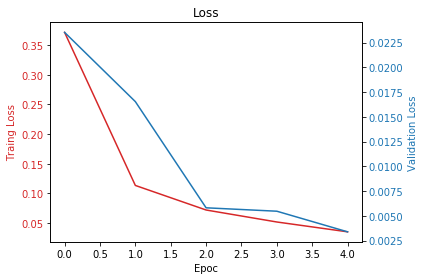

In [60]:
epocs = np.arange(0,num_epochs,1)

fig, ax1 = plt.subplots()
plt.title('Loss')

color = 'tab:red'
ax1.set_xlabel('Epoc')
ax1.set_ylabel('Traing Loss', color=color)
ax1.plot(epocs, history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(epocs, history.history['val_loss'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [61]:
def one_hot_single_class_to_7_class(y_1c):
    sh = y_1c.shape
    y_7c = np.zeros((sh[0], sh[1]+6))
    y_7c[:,6] = y_1c.reshape((sh[0]))
    return y_7c

In [62]:
y1_test_7c = one_hot_single_class_to_7_class(y1_test)
y1_train_7c = one_hot_single_class_to_7_class(y1_train)
print(y1_test_7c.shape)
print(y1_test_7c[0])

(164, 7)
[0. 0. 0. 0. 0. 0. 1.]


In [63]:
test_model_prediction(model_7_classes, x1_test, y1_test_7c, 10)


Overall Score : 0.0%


In [64]:
x_all_train = np.concatenate((x_train, x1_train), axis=0)
x_all_test = np.concatenate((x_test, x1_test), axis=0)
y_all_train = np.concatenate((y_train_7c, y1_train_7c), axis=0)
y_all_test = np.concatenate((y_test_7c, y1_test_7c), axis=0)
print(x_all_train.shape)
print(x_all_test.shape)
print(y_all_train.shape)
print(y_all_test.shape)

(3370, 100, 100, 3)
(1125, 100, 100, 3)
(3370, 7)
(1125, 7)


In [65]:
batch_size = 32
num_epochs = 5
history = model_7_classes.fit(x_all_train, y_all_train,
                              epochs=num_epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_all_test, y_all_test)
                             )

Train on 3370 samples, validate on 1125 samples
Epoch 1/5
3370/3370 [==============================] - 1s 444us/step - loss: 0.1895 - acc: 0.9409 - val_loss: 0.2002 - val_acc: 0.9236
Epoch 2/5
3370/3370 [==============================] - 1s 439us/step - loss: 0.0539 - acc: 0.9840 - val_loss: 0.0690 - val_acc: 0.9707
Epoch 3/5
3370/3370 [==============================] - 1s 444us/step - loss: 0.0374 - acc: 0.9896 - val_loss: 0.0532 - val_acc: 0.9751
Epoch 4/5
3370/3370 [==============================] - 1s 444us/step - loss: 0.0287 - acc: 0.9929 - val_loss: 0.0692 - val_acc: 0.9716
Epoch 5/5
3370/3370 [==============================] - 1s 438us/step - loss: 0.0265 - acc: 0.9932 - val_loss: 0.0456 - val_acc: 0.9716


In [66]:
test_model_prediction(model_7_classes, x_test, y_test_7c, 10)


Overall Score : 90.0%


In [67]:
test_model_prediction(model_7_classes, x1_test, y1_test_7c, 10)


Overall Score : 70.0%


## Articles of Interest

[gpu article 1](https://datascience.stackexchange.com/questions/23895/multi-gpu-in-keras)
[Keras Conv2D](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)